# Практическое занятие №6 и Лабораторная работа №4

Чадов Виктор Тимофеевич ББМО-01-22


In [9]:
# Выполним импорт необходимых библиотек

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [10]:
# Зададим нормализующие преобразования, загрузим набор данных (MNIST), разобьем данные на подвыборки

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

Training data: 50000 Validation data: 10000 Test data: 10000


In [11]:
# Настроим использование графического ускорителя (если возможно)
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

### Создание атак на модель НС

In [12]:
# Создадим класс НС на основе фреймворка torch
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [13]:
# Проверим работоспособность созданного класса НС
model = Net().to(device)

In [14]:
# Создадим оптимизатор, функцию потерь и трейнер сети
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [15]:
# Определим функцию обучения сети
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [16]:
# Обучим модель
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...
Epoch: 1 Loss: 0.263579819603226 Val_Loss: 0.14890895749850921
Epoch: 2 Loss: 0.10970863625072523 Val_Loss: 0.11300506575741578
Epoch: 3 Loss: 0.08571380114189665 Val_Loss: 0.09684921320033377
Epoch: 4 Loss: 0.07492130013927728 Val_Loss: 0.08689195930585827
Epoch: 5 Loss: 0.06871164738990915 Val_Loss: 0.08620033075687401
Epoch: 6 Loss: 0.06286461573341819 Val_Loss: 0.09034419058123229
Epoch: 7 Loss: 0.060639851074379046 Val_Loss: 0.0876196653796555
Epoch: 8 Loss: 0.05655877341710128 Val_Loss: 0.07765546122512587
Epoch: 9 Loss: 0.055284594875473984 Val_Loss: 0.07734055722516957
Epoch: 10 Loss: 0.053049026728175304 Val_Loss: 0.08002814664494123


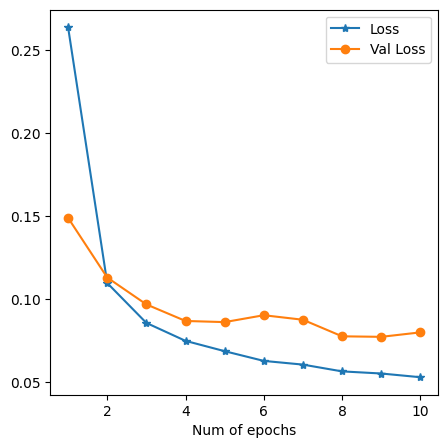

In [17]:
# Построим графики потерь при обучении и валидации в зависимости от эпохи
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [18]:
# Создадим функции атак FGSM, I-FGSM, MI-FGSM
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [19]:
# Создадим функцию проверки
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9702 / 10000 = 0.9702
Epsilon: 0.007	Test Accuracy = 9689 / 10000 = 0.9689
Epsilon: 0.01	Test Accuracy = 9654 / 10000 = 0.9654
Epsilon: 0.02	Test Accuracy = 9607 / 10000 = 0.9607
Epsilon: 0.03	Test Accuracy = 9521 / 10000 = 0.9521
Epsilon: 0.05	Test Accuracy = 9326 / 10000 = 0.9326
Epsilon: 0.1	Test Accuracy = 8385 / 10000 = 0.8385
Epsilon: 0.2	Test Accuracy = 4692 / 10000 = 0.4692
Epsilon: 0.3	Test Accuracy = 2139 / 10000 = 0.2139


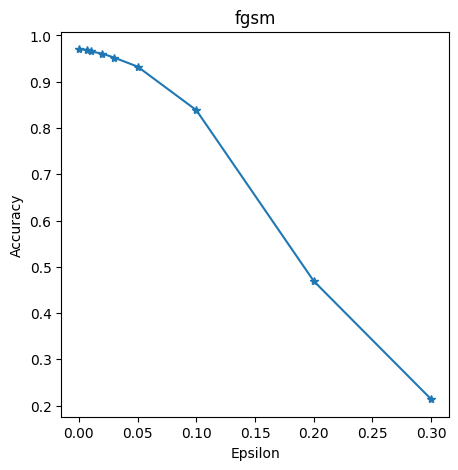

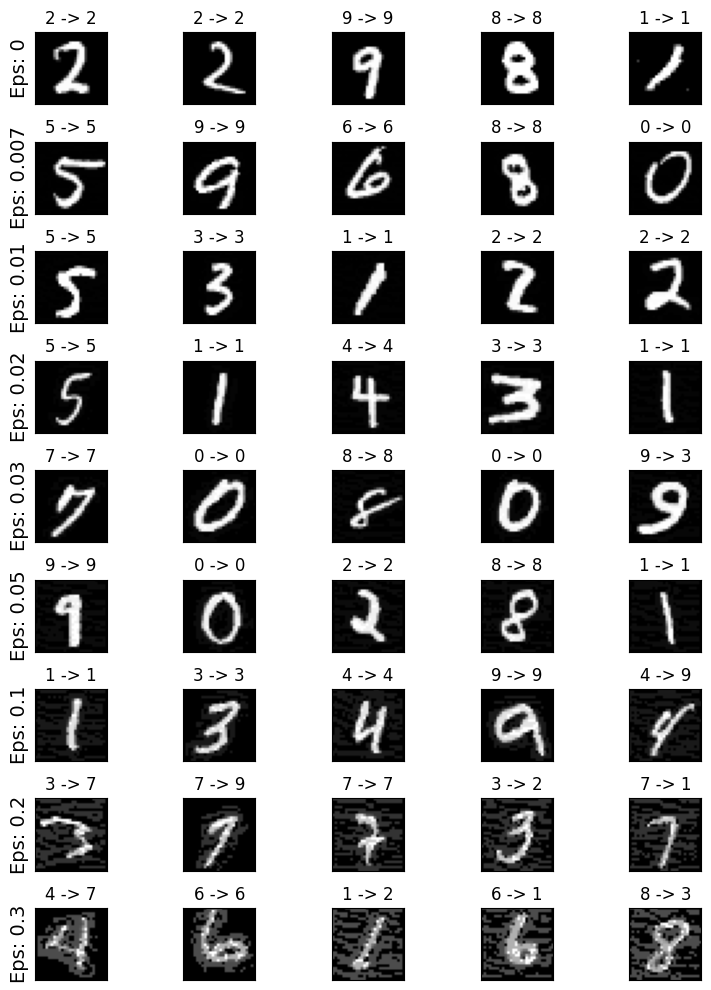

Epsilon: 0	Test Accuracy = 9695 / 10000 = 0.9695
Epsilon: 0.007	Test Accuracy = 9695 / 10000 = 0.9695
Epsilon: 0.01	Test Accuracy = 9663 / 10000 = 0.9663
Epsilon: 0.02	Test Accuracy = 9612 / 10000 = 0.9612
Epsilon: 0.03	Test Accuracy = 9567 / 10000 = 0.9567
Epsilon: 0.05	Test Accuracy = 9362 / 10000 = 0.9362
Epsilon: 0.1	Test Accuracy = 8604 / 10000 = 0.8604
Epsilon: 0.2	Test Accuracy = 5415 / 10000 = 0.5415
Epsilon: 0.3	Test Accuracy = 2642 / 10000 = 0.2642


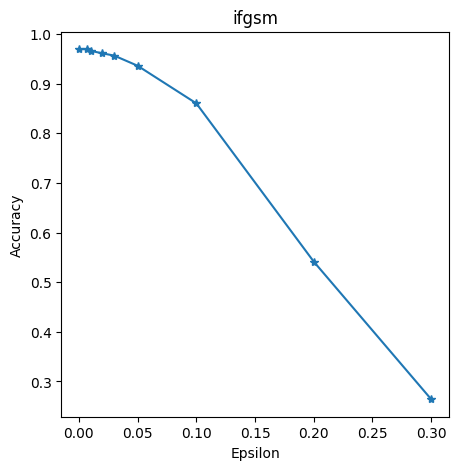

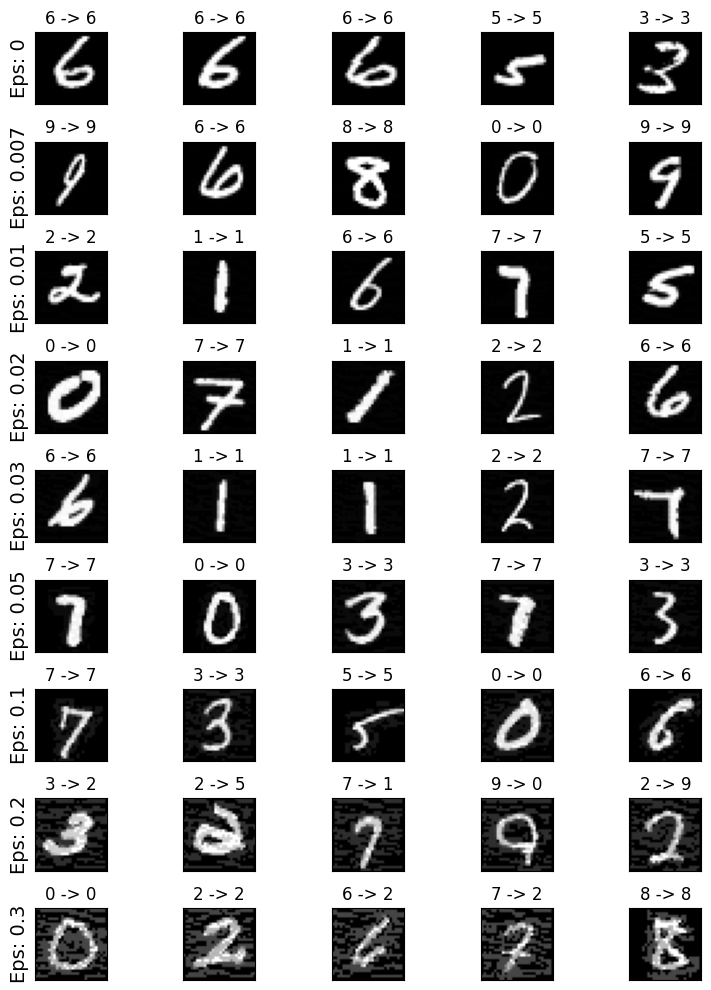

Epsilon: 0	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.007	Test Accuracy = 9687 / 10000 = 0.9687
Epsilon: 0.01	Test Accuracy = 9677 / 10000 = 0.9677
Epsilon: 0.02	Test Accuracy = 9637 / 10000 = 0.9637
Epsilon: 0.03	Test Accuracy = 9559 / 10000 = 0.9559
Epsilon: 0.05	Test Accuracy = 9381 / 10000 = 0.9381
Epsilon: 0.1	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.2	Test Accuracy = 5362 / 10000 = 0.5362
Epsilon: 0.3	Test Accuracy = 2741 / 10000 = 0.2741


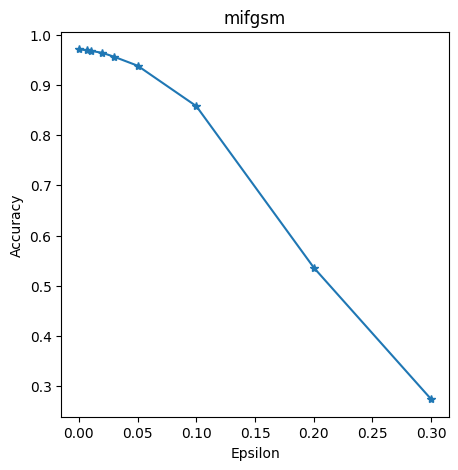

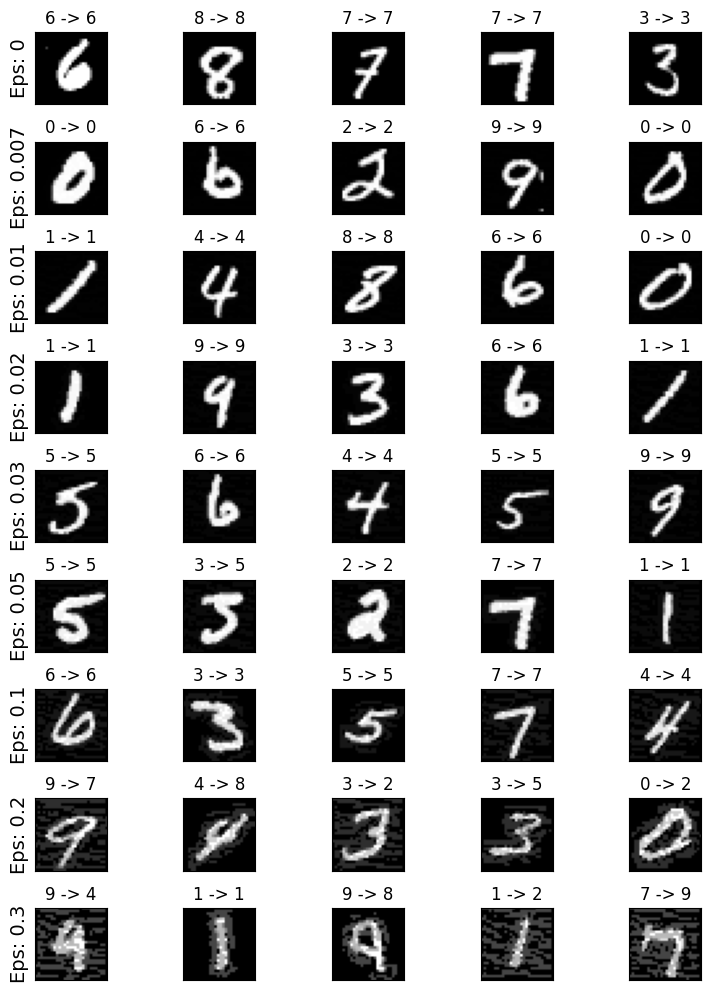

In [20]:
# Построим графики успешности атак (Accuracy/epsilon) и примеры выполненных атак в зависимости от степени возмущения epsilon
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

### Защита от атак

In [21]:
# Создадим 2 класса НС
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [22]:
# Переопределим функцию обучения и тестирования
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

In [23]:
# Создадим функцию защиты методом дистилляции
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5272851744329078 Val_Loss: 5.5524781346321105e-05
Epoch: 2 Loss: 0.31787592442285734 Val_Loss: 4.650194384157657e-06
Epoch: 3 Loss: 0.23792632720279558 Val_Loss: 3.376088979057386e-05
Epoch: 4 Loss: 0.182052935763417 Val_Loss: 0.00022779661151580511
Epoch: 5 Loss: 0.14626357530177797 Val_Loss: 1.5348421702583437e-07
Epoch: 6 Loss: 0.12637782040325007 Val_Loss: 1.2473590059016716e-07
Epoch: 7 Loss: 0.11288573062566692 Val_Loss: 9.155885700238287e-08
Epoch: 8 Loss: 0.10659138384109805 Val_Loss: 1.538873475510627e-08
Epoch: 9 Loss: 0.09621500932793794 Val_Loss: 1.2930497526349427e-05
Epoch: 10 Loss: 0.09394001483975827 Val_Loss: 4.283472933366284e-08


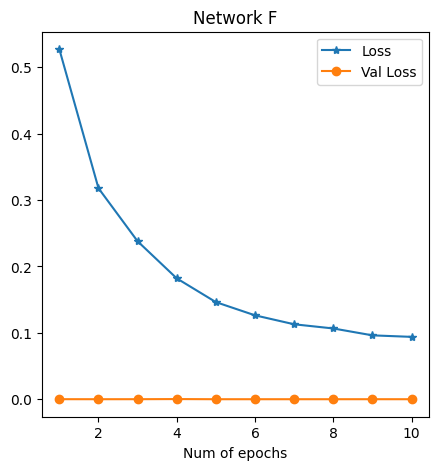

Fitting the model...
Epoch: 1 Loss: 0.7125132415703047 Val_Loss: 1.1349672032520176e-05
Epoch: 2 Loss: 0.47309663637397037 Val_Loss: 0.000179635858466645
Epoch: 3 Loss: 0.41496243319963505 Val_Loss: 5.310683421557769e-05
Epoch: 4 Loss: 0.37556297398012 Val_Loss: 0.00047664408087730407
Epoch: 5 Loss: 0.3283185236994641 Val_Loss: 1.5134256519377232e-05
Epoch: 6 Loss: 0.2885981506364608 Val_Loss: 2.133878832682967e-06
Epoch: 7 Loss: 0.27975001380553405 Val_Loss: 5.153962224721909e-06
Epoch: 8 Loss: 0.27234349789334056 Val_Loss: 2.1134468261152505e-06
Epoch: 9 Loss: 0.26873075429314847 Val_Loss: 3.178433898137882e-05
Epoch: 10 Loss: 0.2629687071870808 Val_Loss: 0.0002251432353630662


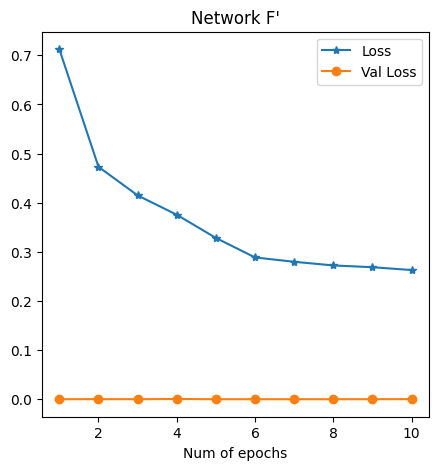

Epsilon: 0	Test Accuracy = 8859 / 10000 = 0.8859
Epsilon: 0.007	Test Accuracy = 8742 / 10000 = 0.8742
Epsilon: 0.01	Test Accuracy = 8804 / 10000 = 0.8804
Epsilon: 0.02	Test Accuracy = 8715 / 10000 = 0.8715
Epsilon: 0.03	Test Accuracy = 8606 / 10000 = 0.8606
Epsilon: 0.05	Test Accuracy = 8418 / 10000 = 0.8418
Epsilon: 0.1	Test Accuracy = 7662 / 10000 = 0.7662
Epsilon: 0.2	Test Accuracy = 4311 / 10000 = 0.4311
Epsilon: 0.3	Test Accuracy = 1657 / 10000 = 0.1657
Epsilon: 0	Test Accuracy = 8843 / 10000 = 0.8843
Epsilon: 0.007	Test Accuracy = 8798 / 10000 = 0.8798
Epsilon: 0.01	Test Accuracy = 8802 / 10000 = 0.8802
Epsilon: 0.02	Test Accuracy = 8755 / 10000 = 0.8755
Epsilon: 0.03	Test Accuracy = 8613 / 10000 = 0.8613
Epsilon: 0.05	Test Accuracy = 8428 / 10000 = 0.8428
Epsilon: 0.1	Test Accuracy = 7656 / 10000 = 0.7656
Epsilon: 0.2	Test Accuracy = 4340 / 10000 = 0.434
Epsilon: 0.3	Test Accuracy = 1590 / 10000 = 0.159
Epsilon: 0	Test Accuracy = 8822 / 10000 = 0.8822
Epsilon: 0.007	Test Accurac

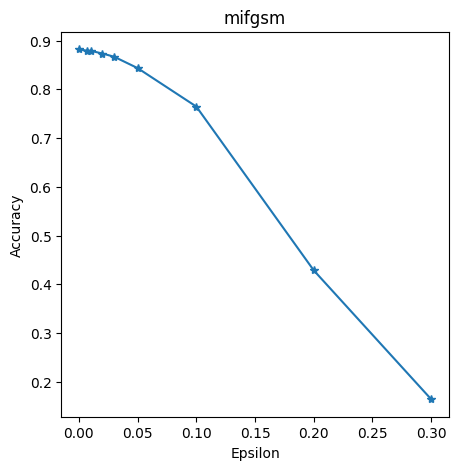

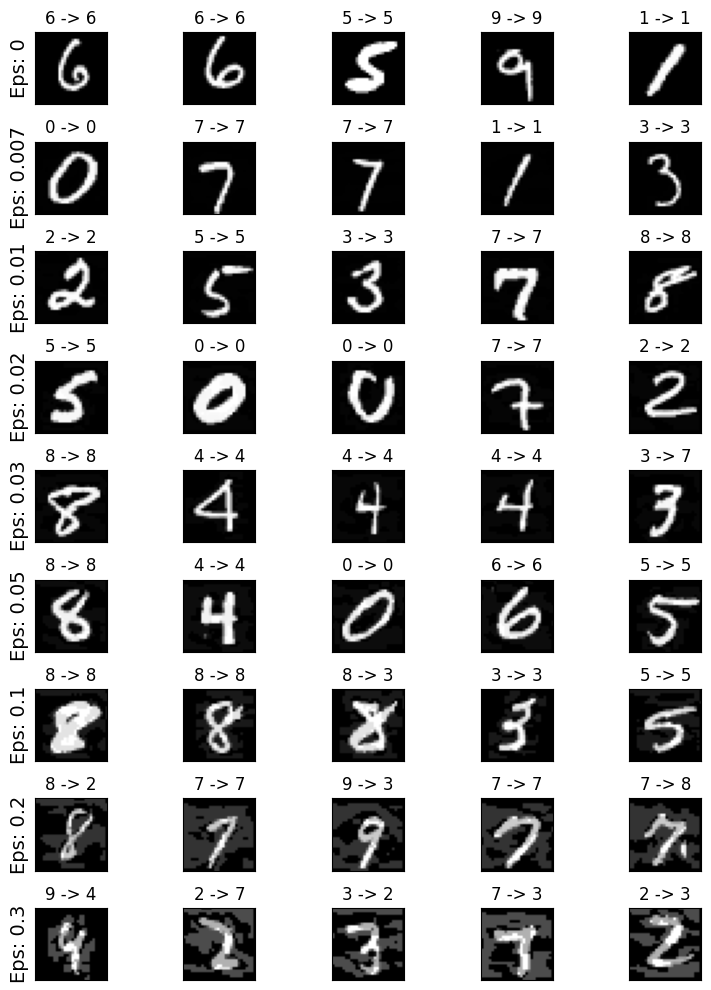

In [24]:
# Получаем результаты оценки защищенных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)


### Выводы:
В данной работе мы успешно создали модели и загрузили данные, обучили их, протестировали и применили защитную дистилляцию.
В целом, защитная дистилляция является полезным методом для уменьшения сложности модели нейронной сети и увеличения скорости обучения и выполнения, но ее эффективность может зависеть от многих факторов, включая сложность исходной модели, качество обучения и размер обучающего набора данных.